# Step 6 - Testing, Deployment and Conclusions

## Goals in this Notebook

## Initialisation

### Imports

In [1]:
import os
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions
import constants
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
)
import joblib

sns.set_palette("colorblind", 10)

### Data

In [4]:
test_sampled_path = os.path.join("data", "acc_test_sampled.parquet")
test_tail_path = os.path.join("data", "acc_test_tail.parquet")
df_test_sampled = pl.read_parquet(test_sampled_path)
df_test_tail = pl.read_parquet(test_tail_path)

excel_path = os.path.join("data", "acc_features.xlsx")
excel_to_drop = functions.get_excel_drop_features(excel_path)

df_test_sampled = (
    df_test_sampled.drop(excel_to_drop)
    .drop(constants.high_corr_to_drop)
    .drop(constants.boruta_to_drop)
    .pipe(functions.cast_wrong_str, cols=constants.wrong_str_to_cast_selected)
    .drop("id")
)
df_test_tail = (
    df_test_tail.drop(excel_to_drop)
    .drop(constants.high_corr_to_drop)
    .drop(constants.boruta_to_drop)
    .pipe(functions.cast_wrong_str, cols=constants.wrong_str_to_cast_selected)
    .drop("id")
)

### Models

In [5]:
preprocessor = joblib.load("models/grade_preprocessor_V1.joblib")
grade_model = joblib.load("models/grade_model_V1.joblib")
subgrade_model = joblib.load("models/subgrade_model_V1.joblib")
int_rate_model = joblib.load("models/int_rate_model_V1.joblib")

## Testing

Split the testing datasets into predictors and targets, preprocess the predictors.

In [6]:
(
    X_test_sampled,
    grade_test_sampled,
    subgrade_test_sampled,
    int_rate_test_sampled,
) = functions.get_test_dfs(df_test_sampled, preprocessor)
(
    X_test_tail,
    grade_test_tail,
    subgrade_test_tail,
    int_rate_test_tail,
) = functions.get_test_dfs(df_test_tail, preprocessor)

### Grade

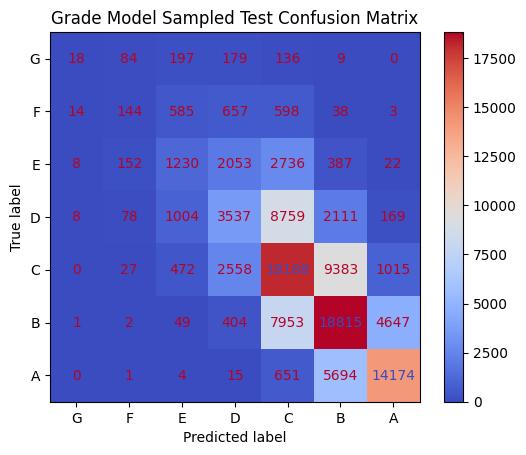

              precision    recall  f1-score   support

           0       0.03      0.37      0.05        49
           1       0.07      0.30      0.11       488
           2       0.19      0.35      0.24      3541
           3       0.23      0.38      0.28      9403
           4       0.57      0.47      0.51     39021
           5       0.59      0.52      0.55     36437
           6       0.69      0.71      0.70     20030

    accuracy                           0.51    108969
   macro avg       0.34      0.44      0.35    108969
weighted avg       0.56      0.51      0.53    108969

RMSE: 0.922
MAE: 0.594


In [7]:
metrics = dict()

y_pred = grade_model.predict(X_test_sampled)
y_true = grade_test_sampled

conf_mx = confusion_matrix(y_true, y_pred)
disp_rf = ConfusionMatrixDisplay(
    confusion_matrix=conf_mx, display_labels=constants.grade_order
)
functions.print_grade_metrics(
    disp_rf, y_true, y_pred, "Grade Model Sampled Test Confusion Matrix"
)
mae = mean_absolute_error(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
metrics["Grade Model Sampled Test"] = {"MAE": mae, "Accuracy": acc}

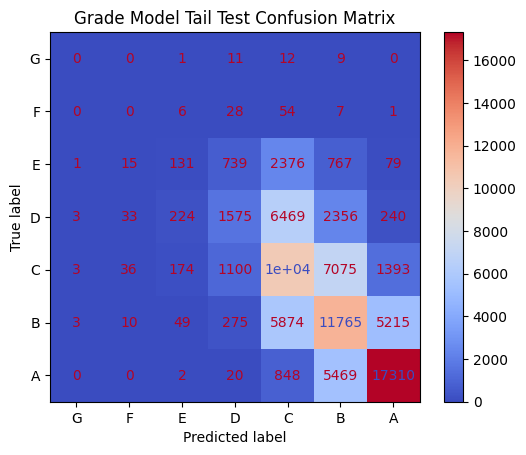

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        94
           2       0.03      0.22      0.06       587
           3       0.14      0.42      0.22      3748
           4       0.51      0.40      0.45     25982
           5       0.51      0.43      0.46     27448
           6       0.73      0.71      0.72     24238

    accuracy                           0.50     82107
   macro avg       0.28      0.31      0.27     82107
weighted avg       0.56      0.50      0.52     82107

RMSE: 0.955
MAE: 0.624


In [8]:
y_pred = grade_model.predict(X_test_tail)
y_true = grade_test_tail

conf_mx = confusion_matrix(y_true, y_pred)
disp_rf = ConfusionMatrixDisplay(
    confusion_matrix=conf_mx, display_labels=constants.grade_order
)
functions.print_grade_metrics(
    disp_rf, y_true, y_pred, "Grade Model Tail Test Confusion Matrix"
)
mae = mean_absolute_error(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
metrics["Grade Model Tail Test"] = {"MAE": mae, "Accuracy": acc}

### Subgrade

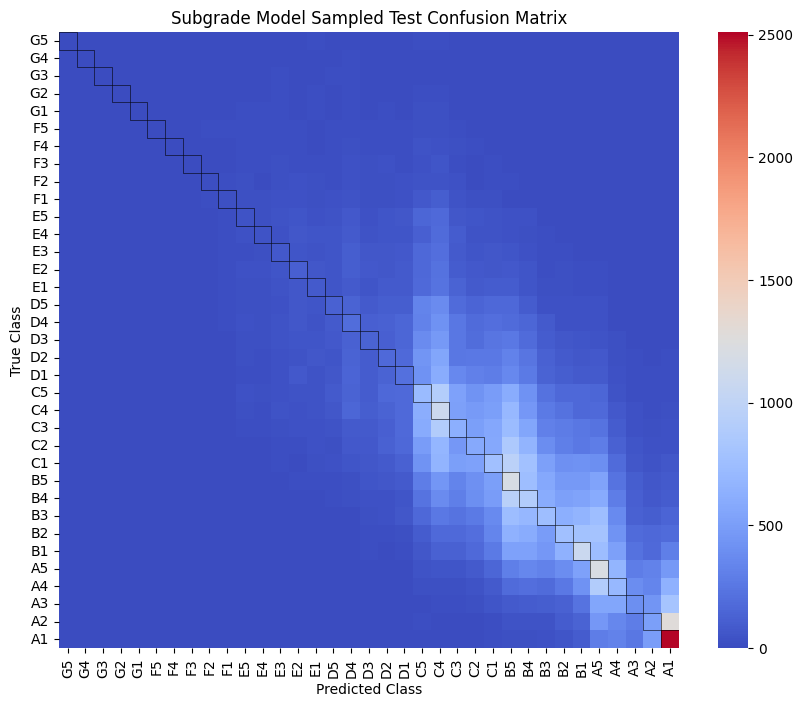

RMSE: 4.794
MAE: 3.511


In [9]:
y_pred = subgrade_model.predict(X_test_sampled)
y_true = subgrade_test_sampled

conf_mx = confusion_matrix(y_true, y_pred)
functions.print_subgrade_metrics(
    conf_mx, y_true, y_pred, "Subgrade Model Sampled Test Confusion Matrix"
)
mae = mean_absolute_error(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
metrics["Subgrade Model Sampled Test"] = {"MAE": mae, "Accuracy": acc}

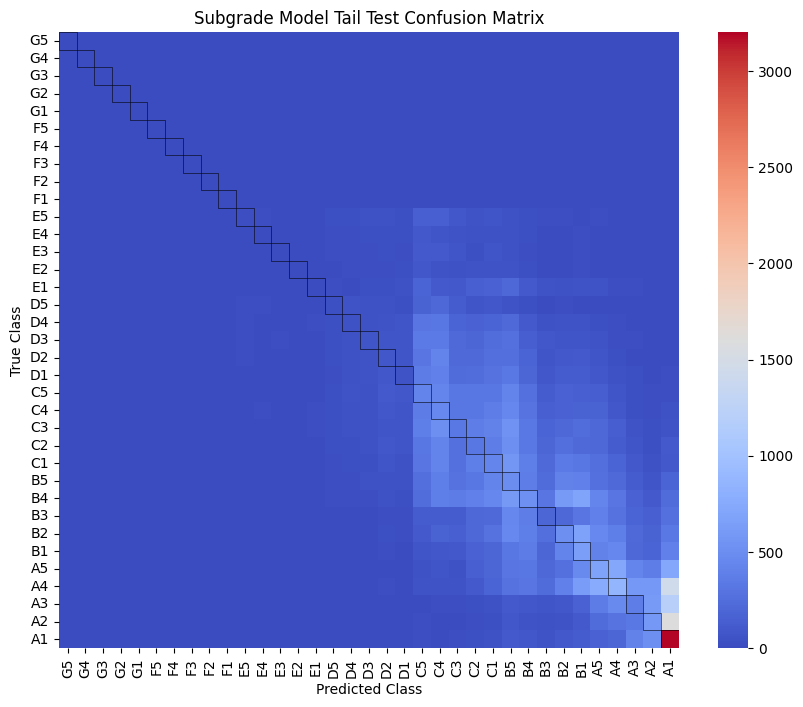

RMSE: 4.965
MAE: 3.699


In [10]:
y_pred = subgrade_model.predict(X_test_tail)
y_true = subgrade_test_tail

conf_mx = confusion_matrix(y_true, y_pred)
functions.print_subgrade_metrics(
    conf_mx, y_true, y_pred, "Subgrade Model Tail Test Confusion Matrix"
)
mae = mean_absolute_error(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
metrics["Subgrade Model Tail Test"] = {"MAE": mae, "Accuracy": acc}

### Interest Rate

RMSE: 3.090
MAE: 2.315


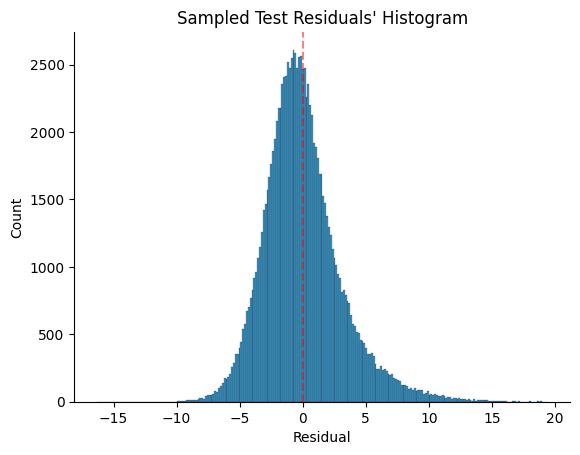

In [11]:
y_pred = int_rate_model.predict(X_test_sampled)
y_true = int_rate_test_sampled
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)
print(f"RMSE: {rmse:2.3f}")
print(f"MAE: {mae:2.3f}")
metrics["Int Rate Model Sampled Test"] = {"MAE": mae}

residuals = y_true.to_numpy().flatten() - y_pred
sns.histplot(residuals)
plt.title("Sampled Test Residuals' Histogram")
plt.xlabel("Residual")
plt.axvline(
    0,
    color="red",
    alpha=0.5,
    ls="--",
)
sns.despine()

RMSE: 3.642
MAE: 2.652


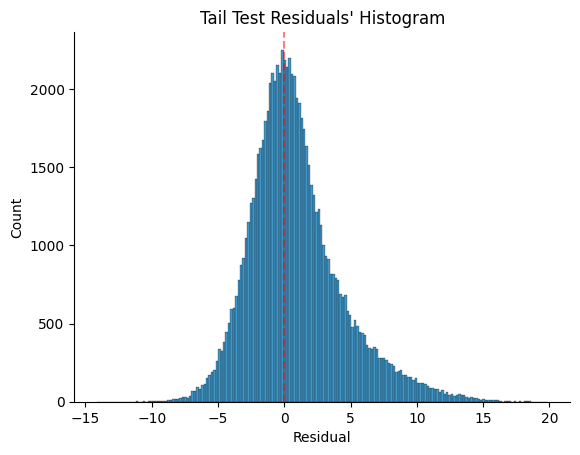

In [12]:
y_pred = int_rate_model.predict(X_test_tail)
y_true = int_rate_test_tail
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)
print(f"RMSE: {rmse:2.3f}")
print(f"MAE: {mae:2.3f}")
metrics["Int Rate Model Tail Test"] = {"MAE": mae}

residuals = y_true.to_numpy().flatten() - y_pred
sns.histplot(residuals)
plt.title("Tail Test Residuals' Histogram")
plt.xlabel("Residual")
plt.axvline(
    0,
    color="red",
    alpha=0.5,
    ls="--",
)
sns.despine()

## Summary

In [13]:
pd.DataFrame(metrics)

,Grade Model Sampled Test,Grade Model Tail Test,Subgrade Model Sampled Test,Subgrade Model Tail Test,Int Rate Model Sampled Test,Int Rate Model Tail Test
MAE,0.593912,0.623735,3.511476,3.699210,2.315469,2.652298
Accuracy,0.514880,0.500932,0.138159,0.125848,NaN,NaN


The validation MAE (Grade: 0.594, Subgrade: 3.596, Interest Rate: 2.309) were similar to the sampled test case. Naturally, the distribution of this test set and validation set is practically the same, as they were sampled across the whole population. 

In the tail test case, our MAE and accuracy both increase - a model trained on historical data will be less accurate for the newer and newer loan applications.

## Deployment

### Ideas

- Flag those predictions that have a low probability (may be hard to do with an ordinal target).
- Introduce a rule base: interest rate can't be lower or higher than some threshold, etc.

Options to deploy all three models:
- One API that handles grading, subgrading ant int rate.
- Three separate APIs in case we need to scale one but not the other.
- If we want to do a step manually and then use model(-s) to do the remaining step(-s), we may want to have models that can effectively use the grading info. The models at hand don't have this.

### Deploy the Model

To run the API on local server:
- Navigate to app/<br>
uvicorn app:app --reload
- http://127.0.0.1:8000/docs has an UI

Steps to get the model on Google Cloud:
- docker build -t NAME .
- docker tag NAME REPO_ON_GOOGLE
- docker push REPO_ON_GOOGLE/NAME
- (run on google cloud run)

Test the model I deployed:
- https://model-cxszazfxuq-nw.a.run.app/docs

Use this dictionary as test input:

{
  "loan_amnt": 2000,
  "term": " 60 months",
  "home_ownership": "OWN",
  "annual_inc": 1000,
  "verification_status": "Verified",
  "purpose": "other",
  "title": "Other",
  "dti": 650,
  "delinq_2yrs": 0,
  "fico_range_high": 0,
  "inq_last_6mths": 0,
  "mths_since_last_delinq": 0,
  "mths_since_last_record": 0,
  "open_acc": 0,
  "pub_rec": 0,
  "revol_bal": 0,
  "revol_util": 0,
  "total_acc": 0,
  "initial_list_status": "w",
  "mths_since_last_major_derog": 0,
  "dti_joint": 0,
  "tot_coll_amt": 0,
  "tot_cur_bal": 0,
  "open_acc_6m": 0,
  "open_act_il": 0,
  "open_il_12m": 0,
  "open_il_24m": 0,
  "mths_since_rcnt_il": 0,
  "total_bal_il": 0,
  "il_util": 0,
  "open_rv_12m": 0,
  "open_rv_24m": 0,
  "max_bal_bc": 0,
  "all_util": 0,
  "total_rev_hi_lim": 0,
  "inq_fi": 0,
  "total_cu_tl": 0,
  "inq_last_12m": 0,
  "acc_open_past_24mths": 0,
  "bc_open_to_buy": 0,
  "bc_util": 0,
  "mo_sin_old_il_acct": 0,
  "mo_sin_old_rev_tl_op": 0,
  "mo_sin_rcnt_rev_tl_op": 0,
  "mo_sin_rcnt_tl": 0,
  "mort_acc": 0,
  "mths_since_recent_bc": 0,
  "mths_since_recent_bc_dlq": 0,
  "mths_since_recent_inq": 0,
  "mths_since_recent_revol_delinq": 0,
  "num_accts_ever_120_pd": 0,
  "num_actv_bc_tl": 0,
  "num_actv_rev_tl": 0,
  "num_bc_sats": 0,
  "num_bc_tl": 0,
  "num_il_tl": 0,
  "num_op_rev_tl": 0,
  "num_rev_accts": 0,
  "num_tl_90g_dpd_24m": 0,
  "num_tl_op_past_12m": 0,
  "pct_tl_nvr_dlq": 0,
  "percent_bc_gt_75": 0,
  "pub_rec_bankruptcies": 0,
  "total_bal_ex_mort": 0,
  "total_bc_limit": 0,
  "sec_app_fico_range_high": 0,
  "disbursement_method": "Cash",
  "earliest_cr_line": "Apr-1990"
}

## Conclusions

In this project, I have explored the rejected and accepted loans datasets and tried my best to achieve the imposed goals. Here are the work results:

 - The data saved in the two datasets follow a different schema, which made it a bit difficult to organise. Moreover, the rejected loans dataset has far less features than the accepted loans dataset. This made it problematic to create a good model. I managed to create one, but since it lacks most of the data for credit risk, I felt reluctant to deploy it. If the stakeholders feel that it would benefit the business, I can easily polish it, test it and deploy it.
 - I performed EDA on the accepted loans dataset. I tried to identify the most and least important features for the targets (grade, subgrade, interest rate) predictions, also identify those features that have great collinearity or leak information from the future.
 - Three models were created tested and deployed, achieving reasonable mean absolute errors - refer to step 6 notebook.

## What Can Be Improved

- EDA could be more in depth, as I skipped quite a few features and didn't explore how they interact with each other. However, having this many features feels like there's an infinite amount of interactions to explore.
- Feature engineering could be improved. Time delta should be calculated instead of raw year/month values. With better EDA, better features could be engineered.
- More models and different preprocessing steps could be explored.
- More time should be spent on tuning and modelling, fitting the whole or at least a bigger portion of the dataset.